In [28]:
import matplotlib.pyplot as plt
from orbit.utils.dataset import load_iclaims

In [29]:
raw_data = load_iclaims()
raw_data

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404
...,...,...,...,...,...,...,...
438,2018-05-27,12.220202,0.116342,-0.004795,0.052260,0.452972,-0.175192
439,2018-06-03,12.162763,0.134360,0.014254,0.052260,0.469082,-0.275119
440,2018-06-10,12.288984,0.134360,0.104405,0.063433,0.469308,-0.291676
441,2018-06-17,12.235743,0.097992,0.104405,0.029532,0.460354,-0.152422


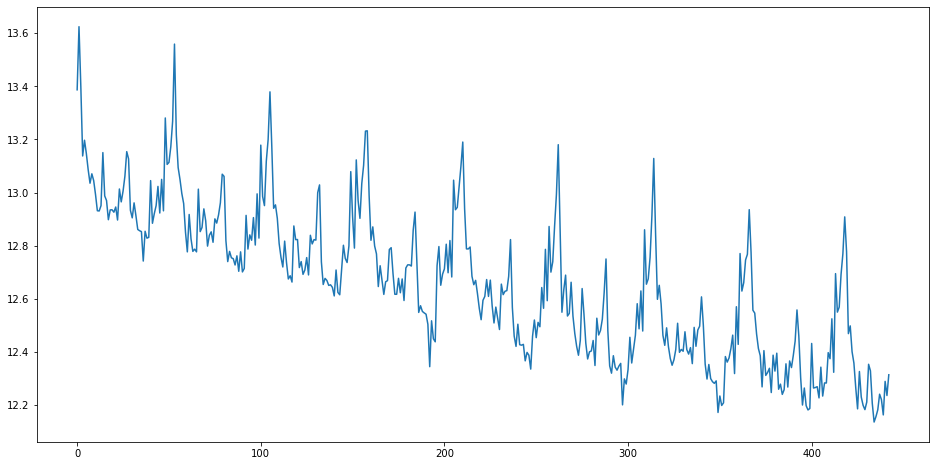

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(raw_data['claims'])

In [ ]:
def ets():
    